# German Traffic Sign Recognition with Tensorflow/Keras

This notebook shows how to recognize german traffic signs with a convolutional deep neural network in TensorFlow. Main Training loop procedure is done with tensorflow only with GradientTape(). 

### The Data

The dataset is from [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) and is available in the pickle data format.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pandas as pd
import random


training_file = 'data/train.p'
testing_file = 'data/test.p'

# converting to pandas dataframe
train = pd.read_pickle(training_file)
test = pd.read_pickle(testing_file)

# split up in features and labels
trainXo, trainY = train['features'], train['labels']
testXo, testY = test['features'], test['labels']

### The Data

Training Images Tensor:  (39209, 32, 32, 3)
Test Images Tensor:   (12630, 32, 32, 3) 

Single Image Tensor shape  = (32, 32, 3)
Available classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}
Number of classes = 43 

Classes: 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42} 

min Value training image: 0 max Value:  255 .


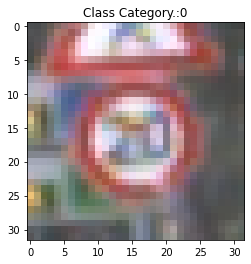

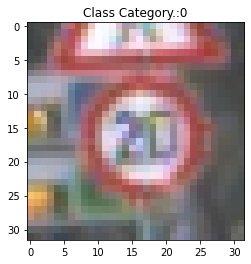

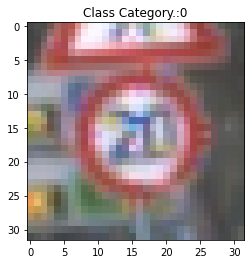

In [2]:
print('Training Images Tensor: ', trainXo.shape)
print('Test Images Tensor:  ', testXo.shape, '\n')

image_shape = (trainXo.shape[1:4])
print('Single Image Tensor shape  =', image_shape)

classes = set(trainY)
print('Available classes: ', classes)
print('Number of classes =', len(classes),'\n')
print('Classes: \n', classes, '\n')

print('min Value training image:', np.min(trainXo), 'max Value: ', np.max(trainXo), '.')

%matplotlib inline
for i in range(0,3):
    plt.imshow(trainXo[i])
    plt.title('Class Category.:' + str(trainY[i]))
    plt.show()

Summary: 
- Train & Test data is not normalized (values go from 0 ... 255)
- The images seem to be ordered --> must be shuffled
- The labels are NOT one-hot-encoded-vectors

### Data normalization
The data is not normalized. In order to handle data efficient for neural networks, data must be normalized usally in range between 0..1 or -1..1 and center it around zero.

In [3]:
#from skimage import color, exposure

def normalize(x):
    '''scaling and shifting tensor elements to -0.5 ... +0.5 '''
    img_max = np.max(x)
    img_min = np.min(x)
    return (x - img_min) / (img_max - img_min) - 0.5


# convert tensor dtype to float
trainX = trainXo.astype(float)
testX = testXo.astype(float)


# apply normalization to both datasets
for i in range(0, trainXo.shape[0]): 
    trainX[i] = normalize(trainXo[i])
    
for i in range(0, testXo.shape[0]):
    testX[i] = normalize(testXo[i])

print('Normalization finished!')

Normalization finished!


### Visualize Dataset again

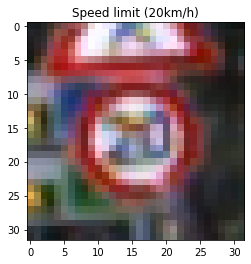

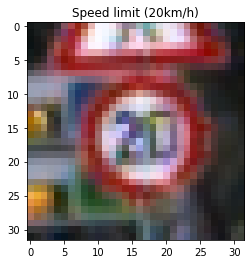

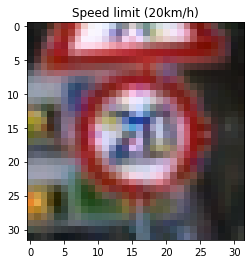

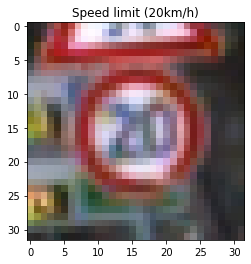

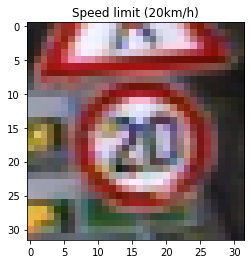

In [4]:
from numpy import genfromtxt

def decodeYtoCorrespondingString(y):
    '''Convert numeric label Y into string'''
    signnames = genfromtxt('signnames.csv', delimiter=',', dtype=str, skip_header = 1)
    string = signnames[y][1]    
    return string  

for i in range(5):
    plt.imshow((trainX[i]+0.5))
    plt.title(decodeYtoCorrespondingString(trainY[i]))
    plt.show()

### Randomly shuffle/permute training and test data

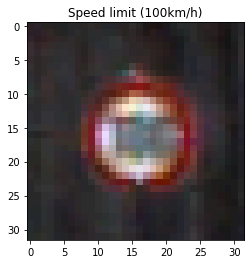

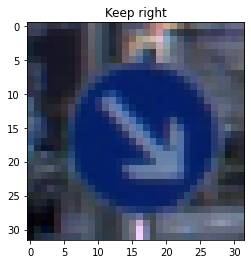

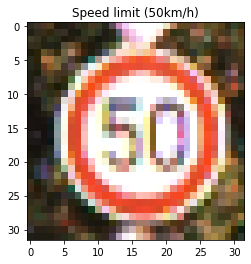

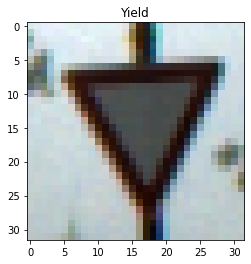

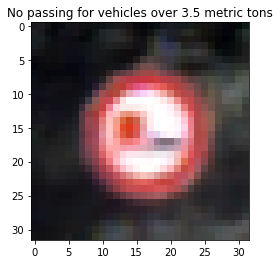

In [5]:
#from sklearn.utils import shuffle

index = np.random.permutation(trainX.shape[0])
trainX, trainY = trainX[index], trainY[index]

index = np.random.permutation(testX.shape[0])
testX, testY = testX[index], testY[index]

for i in range(5):
    plt.imshow(trainX[i]+0.5)
    plt.title(decodeYtoCorrespondingString(trainY[i]))
    plt.show()

### Convert labels to one-hot encoded vectors
Here we use of the to_categorical function of keras. It converts our labels to one-hot-encoded vectors.

In [6]:
from tensorflow.keras.utils import to_categorical

print('labels before: ', trainY[0])

trainY = to_categorical(trainY)
testY  = to_categorical(testY)

print('labels now: ', trainY[0])

labels before:  7
labels now:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### CNN Network Structure

We now want to set up the deep convolutional network.

Input: RGB images of 32x32x3 Elements per Image
Output: Vector with 43 entries (because we have 43 classes)
In Between Structure: See image below!
(Image from Homework of the lecture from Prof. Stache)

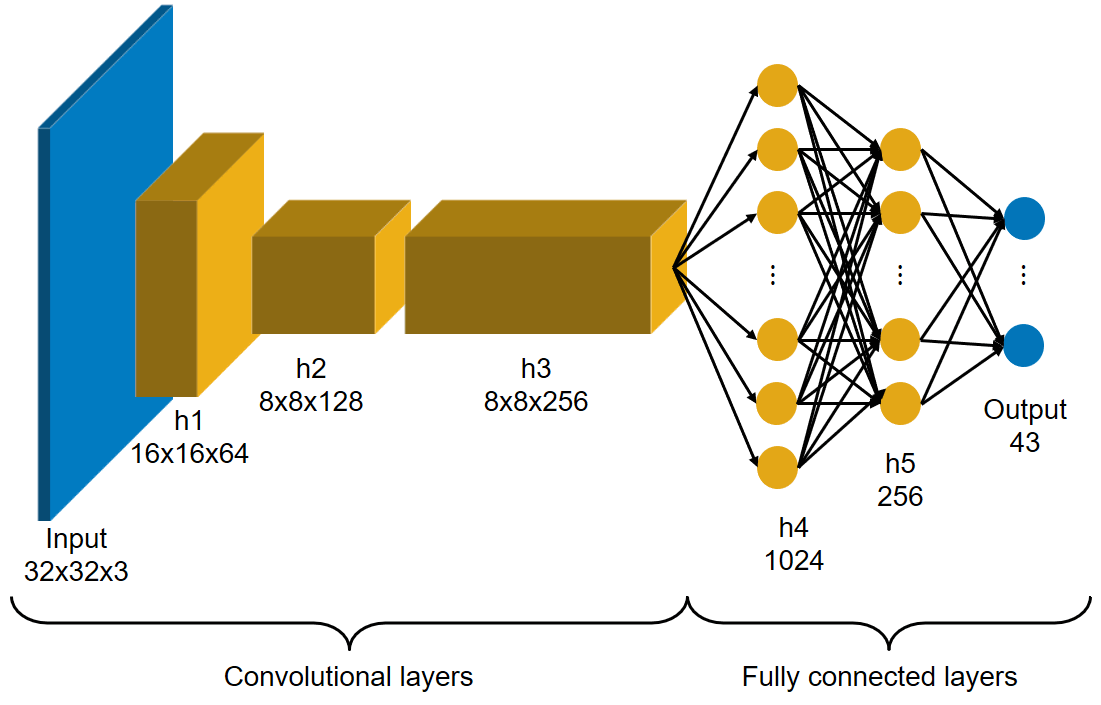

- Input: 32x32x3 Tensor
- h1: 64 filters, shrinking size from 32x32 to 16x16 --> stride=2 --> filter kernel shifted every 2 pixels
- h2: 128 filters, stride=2
- h3: 256 filters, stride=1
- flatten layer
- h4: Dense 1024 neurons
- h5: Dense 256 neurons
- output: Dense 34 neurons, activation=softmax for mapping to logits/ output probabilities

Dropout of 10% --> Better generalizing

In [7]:
from tensorflow.keras import backend as K
K.backend()

'tensorflow'

In [8]:
K.image_data_format()

'channels_last'

In [9]:
trainX.shape, trainY.shape

((39209, 32, 32, 3), (39209, 43))

## Define model with Sequential()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam, SGD



initalizer = TruncatedNormal(stddev=0.1)

def build_network():    
    K.clear_session()
    # Building the model
    model = Sequential()
    
    model.add(Conv2D(64, 3, strides=2, padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(MaxPool2D())
    model.add(Conv2D(128, 3, strides=2, padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(256, 3, strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(43, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = build_network()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

## Define model with Subclassing

In [11]:
class Classifier(tf.keras.Model):
    def __init__(self):
        super(Classifier, self).__init__()
        
        K.clear_session()

        self.layer_1 = Conv2D(64, 3, strides=2, padding='same', activation='relu', input_shape=(None, 32,32,3))
        self.pool_1 = MaxPool2D()
        self.layer_2 = Conv2D(128, 3, strides=2, padding='same', activation='relu')
        self.pool_2 = MaxPool2D()
        self.layer_3 = Conv2D(256, 3, strides=1, padding='same', activation='relu')
        self.pool_3 = MaxPool2D()
        self.flatten = Flatten()
        self.layer_4 = Dense(1024, activation='relu')
        self.layer_5 = Dense(256, activation='relu')
        self.layer_6 = Dense(43, activation='softmax')  # logits layer
        
    def call(self, inputs):
        x = self.pool_1(self.layer_1(inputs))
        x = self.pool_2(self.layer_2(x))
        x = self.pool_3(self.layer_3(x))
        x = self.flatten(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        return self.layer_6(x)
    
model = Classifier()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, 32,32,3))
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0

In [12]:
def generator(X, Y, batch_size=200):
    '''Generator for Training'''
    index = random.sample(range(X.shape[0]), X.shape[0])
    X = X[index, :, :, :]
    Y = Y[index, :]
    
    n_batches = X.shape[0]//batch_size
    for i in range(0, n_batches*batch_size, batch_size):
        x, y = X[i:i+batch_size, :,:,:], Y[i:i+batch_size, :]
        yield x, y

## Main Training loop with Tensorflow

In [13]:
from sklearn.metrics import accuracy_score


epochs = 20
loss_cce = tf.keras.losses.CategoricalCrossentropy()
val_acc_hist, val_loss_hist = [], []
acc_hist, loss_hist = [], []
for e in range(epochs):
    
    acc = 0.0
    batch_number = 0
    for X_batch, Y_batch in generator(trainX, trainY):
        
        with tf.GradientTape() as grad:
            pred = model(X_batch)
            loss = loss_cce(Y_batch, pred)
        
        gradient = grad.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        true_batch = np.argmax(Y_batch, axis=1)
        pred_batch = np.argmax(pred, axis=1)
        acc_batch = accuracy_score(true_batch, pred_batch)
        
        
        if batch_number % 20 == 0:
            # Validation
            pred_val = model(testX)
            true_batch_val = np.argmax(testY, axis=1)
            pred_batch_val = np.argmax(pred_val, axis=1)
            val_acc = accuracy_score(true_batch_val, pred_batch_val)
            print('epoch', e, 'batch_nr', batch_number, 'loss', loss.numpy(), 'acc_batch', acc_batch, 'val_acc', val_acc)
        
        acc_hist.append(acc_batch)
        loss_hist.append(loss.numpy())
        acc += acc_batch
        batch_number += 1
        
    acc = acc/batch_number
    val_acc_hist.append(val_acc)
    print(80*'_')
    print('EPOCH', e, ' running_train_ACC', acc, ' VAL_ACC', val_acc)
    print(80*'_')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch 0 batch_nr 0 loss 3.758149 acc_batch 0.02 val_acc 0.05946159936658749
epoch 0 batch_nr 20 loss 3.392326 acc_batch 0.085 val_acc 0.11353919239904989
epoch 0 batch_nr 40 loss 3.0622663 acc_batch 0.15 val_acc 0.1466349960411718
epoch 0 batch_nr 60 loss 2.5120442 acc_batch 0.27 val_acc 0.2676959619952494
epoch 0 batch_nr 80 loss 2.1093607 acc_batch 0.37 val_acc 0.35257323832145687
epoch 0 batch_nr 100 loss 1.6993852 acc_batch 0.47 val_acc 0.4315914489311164
epoch 0 batch_nr 120 loss 1.4627151 acc_batc

KeyboardInterrupt: 

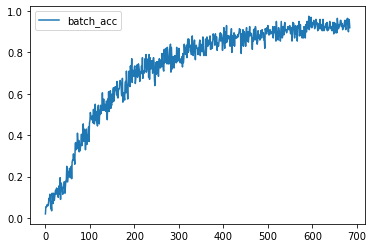

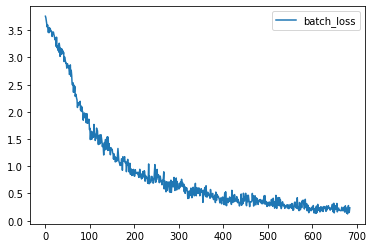

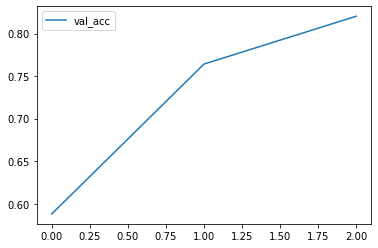

In [14]:
plt.plot(acc_hist, label='batch_acc')
plt.legend()
plt.show()

plt.plot(loss_hist, label='batch_loss')
plt.legend()
plt.show()

val_acc_hist
plt.plot(val_acc_hist, label='val_acc')
plt.legend()
plt.show()

In [16]:
_, val_acc = model.evaluate(testX, testY, verbose=0)
val_acc

0.82414883

## Perform predictions on the trained model

____________________________________________________________________
Prediction: Wild animals crossing


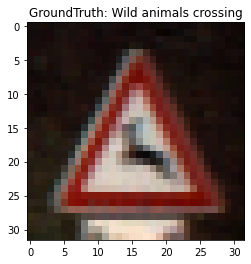

____________________________________________________________________
Prediction: Speed limit (120km/h)


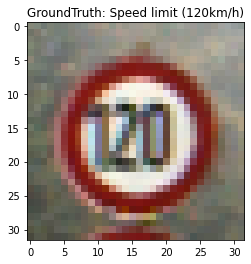

____________________________________________________________________
Prediction: Road work


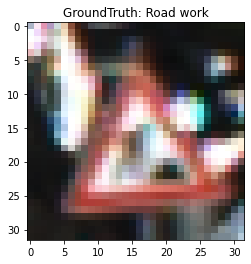

____________________________________________________________________
Prediction: Speed limit (30km/h)


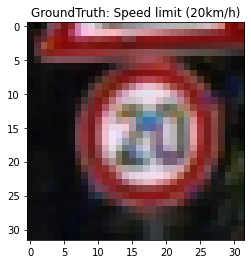

____________________________________________________________________
Prediction: Priority road


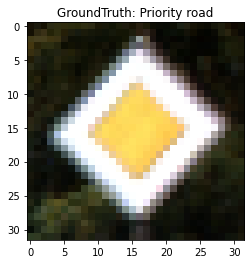

____________________________________________________________________
Prediction: Speed limit (30km/h)


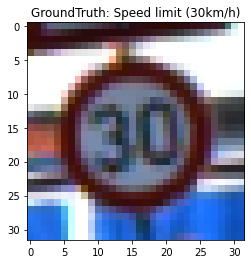

____________________________________________________________________
Prediction: Keep right


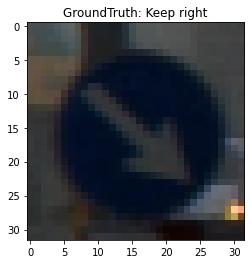

____________________________________________________________________
Prediction: Speed limit (30km/h)


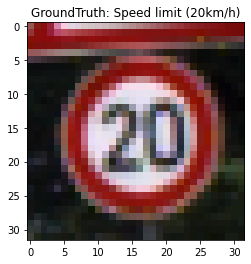

____________________________________________________________________
Prediction: Beware of ice/snow


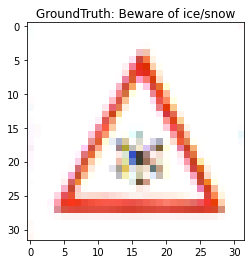

____________________________________________________________________
Prediction: Bumpy road


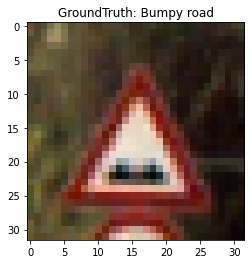

____________________________________________________________________
Prediction: Stop


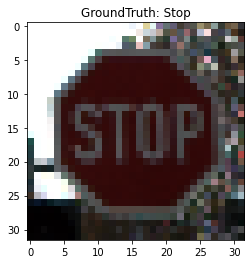

____________________________________________________________________
Prediction: Keep left


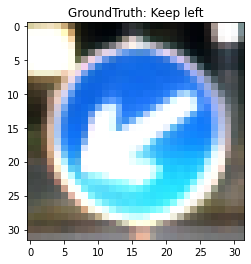

____________________________________________________________________
Prediction: Yield


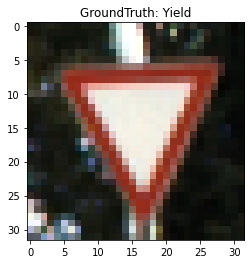

____________________________________________________________________
Prediction: Speed limit (100km/h)


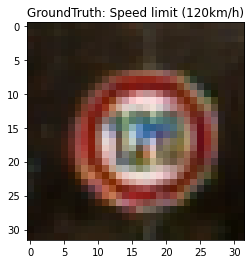

____________________________________________________________________
Prediction: Right-of-way at the next intersection


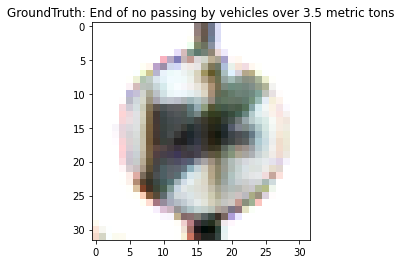

____________________________________________________________________
Prediction: Vehicles over 3.5 metric tons prohibited


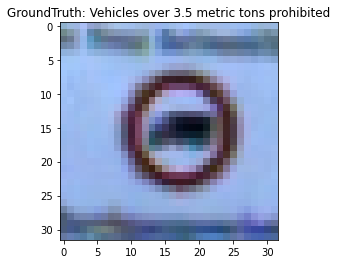

____________________________________________________________________
Prediction: Speed limit (60km/h)


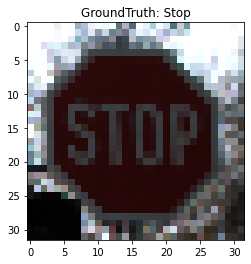

____________________________________________________________________
Prediction: Speed limit (80km/h)


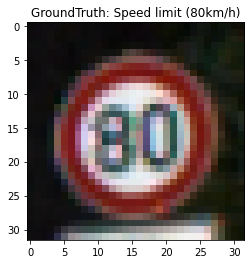

____________________________________________________________________
Prediction: Speed limit (80km/h)


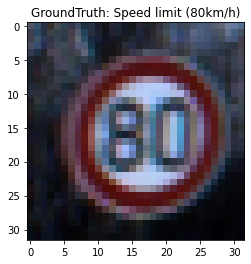

____________________________________________________________________
Prediction: Speed limit (120km/h)


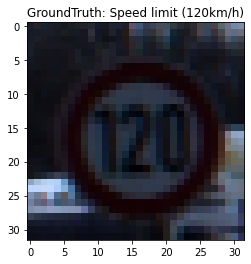

In [28]:
from random import randint

for i in range(20):
    print('____________________________________________________________________')
    i =randint(0, testX.shape[0])
    img = np.expand_dims(testX[i], axis=0)
    prediction2 = model.predict(img)
    print("Prediction:", decodeYtoCorrespondingString(np.argmax(prediction2[0])))

    plt.imshow((testX[i]+0.5))
    plt.title('GroundTruth: ' + decodeYtoCorrespondingString(np.argmax(testY[i])))
    plt.show()

### Improve results with usage of generator with Data Augmentation